In [1]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, BatchNormalization,
                                   Conv1D, MaxPooling1D, GlobalAveragePooling1D,
                                   Input)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


 # Configuration and Setup

In [ ]:

SAMPLING_RATE = 16000
N_MFCC = 13  
N_MELS = 48  
HOP_LENGTH = 512
N_FFT = 1024  
DURATION = 3.5

def load_preprocess(file_path, sr=SAMPLING_RATE, duration=DURATION):
    try:
        x, _ = librosa.load(file_path, sr=sr, duration=duration, offset=0.2)
        x, _ = librosa.effects.trim(x, top_db=30)

        target_length = int(sr * duration)
        if len(x) < target_length:
            x = np.pad(x, (0, target_length - len(x)), mode='constant')
        else:
            x = x[:target_length]

        max_val = np.max(np.abs(x))
        if max_val > 0:
            x = x / max_val
        
        return x
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


 # Feature Extraction Functions

In [3]:
def extract_features_fast(x, sr):
    features = []
    
    # MFCC features
    mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=N_FFT)
    features.extend(np.mean(mfccs.T, axis=0))
    features.extend(np.std(mfccs.T, axis=0))    

    # MFCC Delta
    mfcc_delta = librosa.feature.delta(mfccs)
    features.extend(np.mean(mfcc_delta.T, axis=0))
    
    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH, n_fft=N_FFT)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    features.extend(np.mean(mel_spec_db.T, axis=0))
    
    # Spectral features
    spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr, hop_length=HOP_LENGTH)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr, hop_length=HOP_LENGTH)[0]
    zero_crossing_rate = librosa.feature.zero_crossing_rate(x, hop_length=HOP_LENGTH)[0]
    
    features.extend([
        np.mean(spectral_centroids), np.std(spectral_centroids),
        np.mean(spectral_rolloff), np.std(spectral_rolloff),
        np.mean(zero_crossing_rate), np.std(zero_crossing_rate)
    ])

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=HOP_LENGTH, n_fft=N_FFT)
    features.extend(np.mean(chroma.T, axis=0))
    
    return np.array(features)


 # Data Augmentation Functions

In [ ]:

def simple_augmentation(x, sr):
    augmented_samples = [x] 
    
    # Time stretching
    x_stretched = librosa.effects.time_stretch(x, rate=0.9)
    augmented_samples.append(x_stretched)
    
    # Pitch shifting
    x_pitched = librosa.effects.pitch_shift(x, sr=sr, n_steps=2)
    augmented_samples.append(x_pitched)
    
    # Add noise
    noise = np.random.normal(0, 0.005 * np.max(x), len(x))
    x_noisy = x + noise
    augmented_samples.append(x_noisy)
    
    return augmented_samples

 # CORRECTED Data Loading - Load Original Files Only

In [ ]:
def load_original_data(path, max_files_per_emotion=None):
    original_data = []
    emotion_mapping = {
        1: 0,  # neutral
        2: 1,  # calm
        3: 2,  # happy
        # 4: 3,  # sad
        5: 3,  # angry
        6: 4,  # fearful
        7: 5,  # disgust
        8: 6   # surprised
    }
    
    emotion_counts = {i: 0 for i in range(8)}
    file_count = 0
    
    for fold in os.listdir(path):
        fold_path = os.path.join(path, fold)
        print(fold_path)
        if not os.path.isdir(fold_path):
            continue
            
        for actor in os.listdir(fold_path):
            actor_path = os.path.join(fold_path, actor)
            if not os.path.isdir(actor_path):
                continue
                
            for file in os.listdir(actor_path):
                if not file.endswith('.wav'):
                    continue
                    
                file_path = os.path.join(actor_path, file)
                try:
                    emotion = int(file.split("-")[2])
                    if emotion in emotion_mapping:
                        emotion_idx = emotion_mapping[emotion]
                        
                        if max_files_per_emotion and emotion_counts[emotion_idx] >= max_files_per_emotion:
                            continue
                        
                        # Store file path and emotion - we'll process audio later
                        original_data.append((file_path, emotion_idx))
                        emotion_counts[emotion_idx] += 1
                        file_count += 1
                        
                        if file_count % 50 == 0:
                            print(f"Found {file_count} files...")
                            
                except Exception as e:
                    print(f"Error processing {file}: {e}")
                    continue
    
    print(f"Found {len(original_data)} original audio files")
    return original_data


In [ ]:
def process_audio_files(file_emotion_pairs, apply_augmentation=False):
    processed_data = []
    
    for i, (file_path, emotion_idx) in enumerate(file_emotion_pairs):
        try:
            x = load_preprocess(file_path, SAMPLING_RATE)
            if x is None:
                continue
            
            if apply_augmentation:
                features = extract_features_fast(x, SAMPLING_RATE)
                processed_data.append((features, emotion_idx))

                augmented_samples = simple_augmentation(x, SAMPLING_RATE)
                for aug_x in augmented_samples:
                    features = extract_features_fast(aug_x, SAMPLING_RATE)
                    processed_data.append((features, emotion_idx))
            else:
                features = extract_features_fast(x, SAMPLING_RATE)
                processed_data.append((features, emotion_idx))
            
            if (i + 1) % 50 == 0:
                print(f"Processed {i + 1}/{len(file_emotion_pairs)} files...")
                
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    return processed_data


 # Model Architecture Functions

In [ ]:
def create_compact_model(input_shape, num_classes):
    """Create a compact dense neural network"""
    model = Sequential([
        Dense(512, input_shape=(input_shape,), activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(64, activation='relu'),
        Dropout(0.2),
        
        Dense(num_classes, activation='softmax')
    ],name = "LOOOOOOOO")
    
    return model


 # Main Training Pipeline - CORRECTED APPROACH

In [26]:
# Set your data path
path = r"C:\Users\jangi\OneDrive\Desktop\Mars Project\data\audios"

print("Step 1: Loading original file information...")
original_data = load_original_data(path, max_files_per_emotion=300)


print("\nStep 2: Splitting original data...")
file_paths, emotions = zip(*original_data)


train_files, test_files, train_emotions, test_emotions = train_test_split(
    file_paths, emotions, 
    test_size=0.2, 
    random_state=42, 
    stratify=emotions, 
    shuffle=True
)

print(f"Training files: {len(train_files)}")
print(f"Test files: {len(test_files)}")

print("\nStep 3: Processing training data with augmentation...")
train_pairs = list(zip(train_files, train_emotions))
train_processed = process_audio_files(train_pairs, apply_augmentation=True)

print("\nStep 4: Processing test data without augmentation...")
test_pairs = list(zip(test_files, test_emotions))
test_processed = process_audio_files(test_pairs, apply_augmentation=False)

print("\nExtracting features and labels...")
X_train, y_train = zip(*train_processed)
X_test, y_test = zip(*test_processed)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")


Step 1: Loading original file information...
C:\Users\jangi\OneDrive\Desktop\Mars Project\data\audios\Audio_Song_Actors_01-24
Found 50 files...
Found 100 files...
Found 150 files...
Found 200 files...
Found 250 files...
Found 300 files...
Found 350 files...
Found 400 files...
Found 450 files...
Found 500 files...
Found 550 files...
Found 600 files...
Found 650 files...
Found 700 files...
Found 750 files...
Found 800 files...
C:\Users\jangi\OneDrive\Desktop\Mars Project\data\audios\Audio_Speech_Actors_01-24
Found 850 files...
Found 900 files...
Found 950 files...
Found 1000 files...
Found 1050 files...
Found 1100 files...
Found 1150 files...
Found 1200 files...
Found 1250 files...
Found 1300 files...
Found 1350 files...
Found 1400 files...
Found 1450 files...
Found 1500 files...
Found 1550 files...
Found 1600 files...
Found 1650 files...
Found 1700 files...
Found 1750 files...
Found 1772 original audio files

Step 2: Splitting original data...
Training files: 1417
Test files: 355

Step 

Processed 50/1417 files...
Processed 100/1417 files...
Processed 150/1417 files...
Processed 200/1417 files...
Processed 250/1417 files...
Processed 300/1417 files...
Processed 350/1417 files...
Processed 400/1417 files...
Processed 450/1417 files...
Processed 500/1417 files...
Processed 550/1417 files...
Processed 600/1417 files...
Processed 650/1417 files...
Processed 700/1417 files...
Processed 750/1417 files...
Processed 800/1417 files...
Processed 850/1417 files...
Processed 900/1417 files...
Processed 950/1417 files...
Processed 1000/1417 files...
Processed 1050/1417 files...
Processed 1100/1417 files...
Processed 1150/1417 files...
Processed 1200/1417 files...
Processed 1250/1417 files...
Processed 1300/1417 files...
Processed 1350/1417 files...
Processed 1400/1417 files...

Step 4: Processing test data without augmentation...
Processed 50/355 files...
Processed 100/355 files...
Processed 150/355 files...
Processed 200/355 files...
Processed 250/355 files...
Processed 300/355 fi

 # Data Preprocessing and Scaling

In [ ]:

save_dir = 'C:\\Users\\jangi\\OneDrive\\Desktop\\Mars Project\\saved'

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

joblib.dump(scaler, os.path.join(save_dir, 'scaler_.joblib'))

print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")


Scaled training set shape: (7085, 105)
Scaled test set shape: (355, 105)


 # Model Creation and Training

In [ ]:

model = create_compact_model(X_train_scaled.shape[1], len(np.unique(y_train)))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "LOOOOOOOO"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 512)            │        54,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,791 (901.53 KB)

 Trainable params: 228,999 (894.53 KB)

 Non-trainable params: 1,792 (7.00 KB)

In [29]:
# Define callbacks
callbacks = [
    ModelCheckpoint(
        os.path.join(save_dir, 'best_model_corrected.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]


In [ ]:
# Train model
print("Training model...")
history = model.fit(
    X_train_scaled, y_train,
    batch_size=64,
    epochs=100,
    validation_split=0.2, 
    callbacks=callbacks,
    verbose=1
)


Training model...
Epoch 1/100
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2594 - loss: 2.0796
Epoch 1: val_accuracy improved from -inf to 0.47848, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2633 - loss: 2.0654 - val_accuracy: 0.4785 - val_loss: 1.4602 - learning_rate: 0.0010
Epoch 2/100
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5110 - loss: 1.2851
Epoch 2: val_accuracy improved from 0.47848 to 0.55046, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5118 - loss: 1.2825 - val_accuracy: 0.5505 - val_loss: 1.1836 - learning_rate: 0.0010
Epoch 3/100
84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6063 - loss: 1.0586
Epoch 3: val_accuracy improved from 0.55046 to 0.62668, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6065 - loss: 1.0583 - val_accuracy: 0.6267 - val_loss: 1.0197 - learning_rate: 0.0010
Epoch 4/100
83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6605 - loss: 0.9152
Epoch 4: val_accuracy improved from 0.62668 to 0.63797, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6614 - loss: 0.9126 - val_accuracy: 0.6380 - val_loss: 0.9624 - learning_rate: 0.0010
Epoch 5/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7115 - loss: 0.7914
Epoch 5: val_accuracy improved from 0.63797 to 0.68596, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7114 - loss: 0.7913 - val_accuracy: 0.6860 - val_loss: 0.8365 - learning_rate: 0.0010
Epoch 6/100
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7281 - loss: 0.7160
Epoch 6: val_accuracy did not improve from 0.68596
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7283 - loss: 0.7157 - val_accuracy: 0.6853 - val_loss: 0.8357 - learning_rate: 0.0010
Epoch 7/100
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7506 - loss: 0.6752
Epoch 7: val_accuracy improved from 0.68596 to 0.70501, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7507 - loss: 0.6749 - val_accuracy: 0.7050 - val_loss: 0.8027 - learning_rate: 0.0010
Epoch 8/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7794 - loss: 0.6134
Epoch 8: val_accuracy did not improve from 0.70501
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7791 - loss: 0.6136 - val_accuracy: 0.7043 - val_loss: 0.8425 - learning_rate: 0.0010
Epoch 9/100
80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7830 - loss: 0.5747
Epoch 9: val_accuracy improved from 0.70501 to 0.71348, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7828 - loss: 0.5764 - val_accuracy: 0.7135 - val_loss: 0.7982 - learning_rate: 0.0010
Epoch 10/100
82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7988 - loss: 0.5536
Epoch 10: val_accuracy improved from 0.71348 to 0.73112, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7991 - loss: 0.5526 - val_accuracy: 0.7311 - val_loss: 0.7794 - learning_rate: 0.0010
Epoch 11/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8180 - loss: 0.5098
Epoch 11: val_accuracy improved from 0.73112 to 0.75159, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8179 - loss: 0.5100 - val_accuracy: 0.7516 - val_loss: 0.7062 - learning_rate: 0.0010
Epoch 12/100
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8421 - loss: 0.4671
Epoch 12: val_accuracy did not improve from 0.75159
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8416 - loss: 0.4675 - val_accuracy: 0.7156 - val_loss: 0.8036 - learning_rate: 0.0010
Epoch 13/100
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8560 - loss: 0.4306
Epoch 13: val_accuracy did not improve from 0.75159
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8556 - loss: 0.4317 - val_accuracy: 0.7283 - val_loss: 0.7768 - learning_rate: 0.0010
Epoch 14/100
84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8341 - loss: 0.4717
Epoch 14: val_accuracy did not improve from 0.75159
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8346 - loss: 0.4699 - val_accuracy: 0.7459 - val_loss: 0.7906 - learning_rate: 0.0010
Epoch 15/100
89/89 ━━━━━━

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8493 - loss: 0.4281 - val_accuracy: 0.7544 - val_loss: 0.7486 - learning_rate: 0.0010
Epoch 16/100
84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8477 - loss: 0.4118
Epoch 16: val_accuracy improved from 0.75441 to 0.76217, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8476 - loss: 0.4125 - val_accuracy: 0.7622 - val_loss: 0.6965 - learning_rate: 0.0010
Epoch 17/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8632 - loss: 0.3853
Epoch 17: val_accuracy improved from 0.76217 to 0.76429, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8632 - loss: 0.3854 - val_accuracy: 0.7643 - val_loss: 0.7046 - learning_rate: 0.0010
Epoch 18/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8616 - loss: 0.3792
Epoch 18: val_accuracy did not improve from 0.76429
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8616 - loss: 0.3790 - val_accuracy: 0.7594 - val_loss: 0.7377 - learning_rate: 0.0010
Epoch 19/100
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8713 - loss: 0.3565
Epoch 19: val_accuracy did not improve from 0.76429
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8714 - loss: 0.3566 - val_accuracy: 0.7615 - val_loss: 0.7546 - learning_rate: 0.0010
Epoch 20/100
83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8759 - loss: 0.3483
Epoch 20: val_accuracy did not improve from 0.76429
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8757 - loss: 0.3487 - val_accuracy: 0.7565 - val_loss: 0.7320 - learning_rate: 0.0010
Epoch 21/100
87/89 ━━━━━━


Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8796 - loss: 0.3374 - val_accuracy: 0.7749 - val_loss: 0.7369 - learning_rate: 0.0010
Epoch 22/100
84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8969 - loss: 0.2885
Epoch 22: val_accuracy did not improve from 0.77488
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8976 - loss: 0.2872 - val_accuracy: 0.7735 - val_loss: 0.7056 - learning_rate: 5.0000e-04
Epoch 23/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9287 - loss: 0.2242
Epoch 23: val_accuracy improved from 0.77488 to 0.78829, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9283 - loss: 0.2248 - val_accuracy: 0.7883 - val_loss: 0.6937 - learning_rate: 5.0000e-04
Epoch 24/100
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9121 - loss: 0.2423
Epoch 24: val_accuracy did not improve from 0.78829
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9122 - loss: 0.2423 - val_accuracy: 0.7735 - val_loss: 0.6992 - learning_rate: 5.0000e-04
Epoch 25/100
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9241 - loss: 0.2144
Epoch 25: val_accuracy did not improve from 0.78829
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9240 - loss: 0.2147 - val_accuracy: 0.7798 - val_loss: 0.7155 - learning_rate: 5.0000e-04
Epoch 26/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9285 - loss: 0.2128
Epoch 26: val_accuracy did not improve from 0.78829
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9285 - loss: 0.2128 - val_accuracy: 0.7805 - val_loss: 0.6984 - learning_rate: 5.0000e-04
Epoch 27/

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9236 - loss: 0.2058 - val_accuracy: 0.7939 - val_loss: 0.7011 - learning_rate: 5.0000e-04
Epoch 28/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9209 - loss: 0.2169
Epoch 28: val_accuracy did not improve from 0.79393

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9210 - loss: 0.2166 - val_accuracy: 0.7784 - val_loss: 0.7445 - learning_rate: 5.0000e-04
Epoch 29/100
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9303 - loss: 0.1969
Epoch 29: val_accuracy did not improve from 0.79393
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9305 - loss: 0.1963 - val_accuracy: 0.7876 - val_loss: 0.6718 - learning_rate: 2.5000e-04
Epoch 30/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9436 - loss: 0.1642
Epoch 30: val_accuracy did not improve from 0.79393
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9436 - loss: 0.1642

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9470 - loss: 0.1520 - val_accuracy: 0.7989 - val_loss: 0.6873 - learning_rate: 1.2500e-04
Epoch 36/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9519 - loss: 0.1275
Epoch 36: val_accuracy did not improve from 0.79887
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9519 - loss: 0.1277 - val_accuracy: 0.7953 - val_loss: 0.6892 - learning_rate: 1.2500e-04
Epoch 37/100
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9522 - loss: 0.1358
Epoch 37: val_accuracy improved from 0.79887 to 0.80169, saving model to C:\Users\jangi\OneDrive\Desktop\Mars Project\saved\best_model_corrected.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9521 - loss: 0.1358 - val_accuracy: 0.8017 - val_loss: 0.6919 - learning_rate: 1.2500e-04
Epoch 38/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9536 - loss: 0.1345
Epoch 38: val_accuracy did not improve from 0.80169
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9537 - loss: 0.1342 - val_accuracy: 0.7960 - val_loss: 0.7150 - learning_rate: 1.2500e-04
Epoch 39/100
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9544 - loss: 0.1261
Epoch 39: val_accuracy did not improve from 0.80169

Epoch 39: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9544 - loss: 0.1259 - val_accuracy: 0.7989 - val_loss: 0.7059 - learning_rate: 1.2500e-04
Epoch 40/100
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9601 - loss: 0.1213
Epoch 40: val_accuracy did not improve from 0.80169
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9601 - loss: 0.1212 -

 # Model Evaluation

In [31]:
X_test_scaled.shape

(355, 105)

In [32]:
# Evaluate on test set
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Test Accuracy: 0.8028

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        38
           1       0.84      0.87      0.85        60
           2       0.81      0.78      0.80        60
           3       0.81      0.85      0.83        60
           4       0.77      0.78      0.78        60
           5       0.87      0.69      0.77        39
           6       0.75      0.87      0.80        38

    accuracy                           0.80       355
   macro avg       0.80      0.80      0.80       355
weighted avg       0.80      0.80      0.80       355



 # Visualization and Analysis

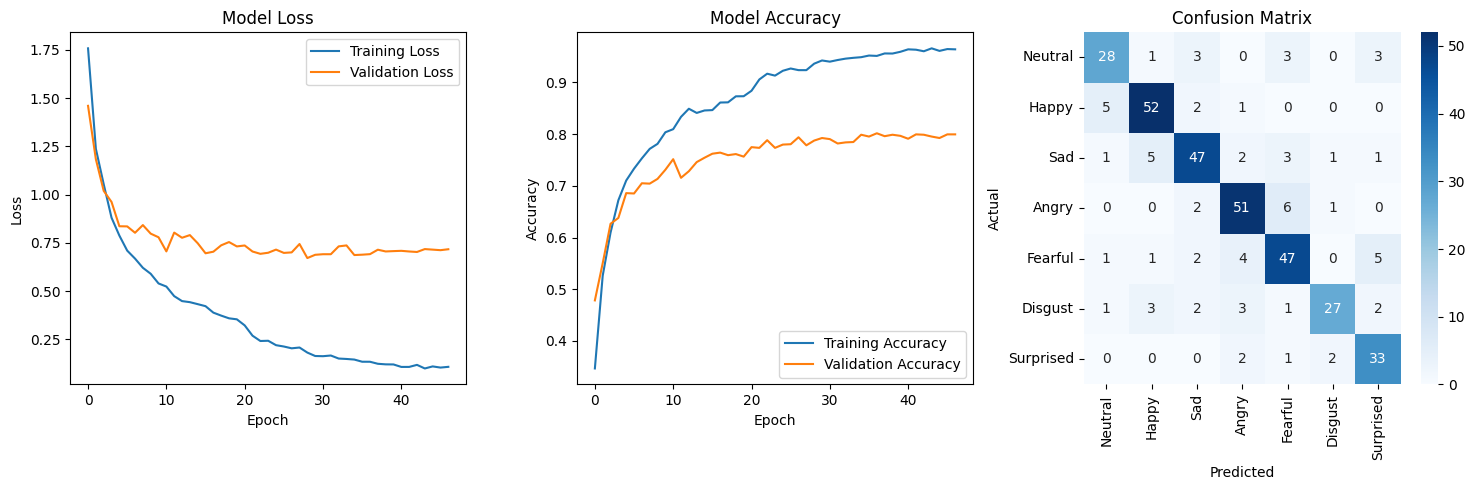

In [33]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
emotion_labels = ['Neutral', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()
